# Package and Data

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from torch import nn, optim
from PIL import Image
file_dir  = "../input/humpback-whale-identification/train"
df = pd.read_csv("../input/humpback-whale-identification/train.csv")

In [2]:
train = df[df["Id"] != "new_whale"]
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
6,000a6daec.jpg,w_dd88965
8,0016b897a.jpg,w_64404ac


In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def get_encoder(x):
    values = np.array(x)
    le = LabelEncoder()
    int_label =le.fit_transform(values)    
    ohe = OneHotEncoder(sparse =False)
    int_label = int_label.reshape(len(int_label),1)
    ohe.fit(int_label)
    return le,ohe

In [4]:
le, ohe = get_encoder(train["Id"])

In [5]:
def prepare_label(x,le,ohe):
    values = np.array(x)   
    int_label = le.transform(values)
    
    int_label = int_label.reshape(len(int_label),1)
    onehot_label = ohe.transform(int_label)
    
    y = onehot_label
    return y

In [6]:
used_id = train["Id"].value_counts()[train["Id"].value_counts()<=5]
new_train = train[train["Id"].isin(used_id.index)]

In [7]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2)

In [8]:
train = pd.concat((train, new_train), axis = 0)

In [9]:
train_labels = prepare_label(train["Id"],le,ohe)
val_labels = prepare_label(val["Id"],le,ohe)

# Data Channels

In [10]:
class WhaleDataset(Dataset):
    def __init__(self, df, file_dir, labels = None, mode = "train", transform = None):
        self.df = df
        self.file_dir = file_dir
        self.labels = labels
        self.mode = mode
        self.transform = transform
        
    def __getitem__(self, index):
        image_name = self.df["Image"].iloc[index]
        label = self.labels[index]
        
        image = Image.open(os.path.join(self.file_dir,image_name))
        image = image.resize((384,384))
        image = image.convert("RGB")
        
        if self.transform != None:
            image = self.transform(image)
        if self.mode == "train" or self.mode == "val":
            return image, label
        else:
            return image
    
    def __len__(self):
        return self.df.shape[0]

In [11]:
flip_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1),
                                     transforms.RandomGrayscale(),
                                     transforms.RandomRotation(15),
                                     transforms.GaussianBlur(3),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
regular_transform = transforms.Compose([transforms.RandomGrayscale(),
                                       transforms.RandomRotation(15),
                                       transforms.GaussianBlur(3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [12]:
pretrain_data = WhaleDataset(train[:500], file_dir, labels = train_labels[:500], transform =regular_transform) 
train_data = WhaleDataset(train, file_dir, labels = train_labels, transform =regular_transform)
new_data = WhaleDataset(train, file_dir, labels = train_labels, transform =flip_transform)
val_data = WhaleDataset(val, file_dir, labels = val_labels, transform =val_transform)
train_data = torch.utils.data.ConcatDataset([train_data, new_data])

In [13]:
pretrain_loader = DataLoader(pretrain_data, batch_size = 32, shuffle=True)
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle=True)

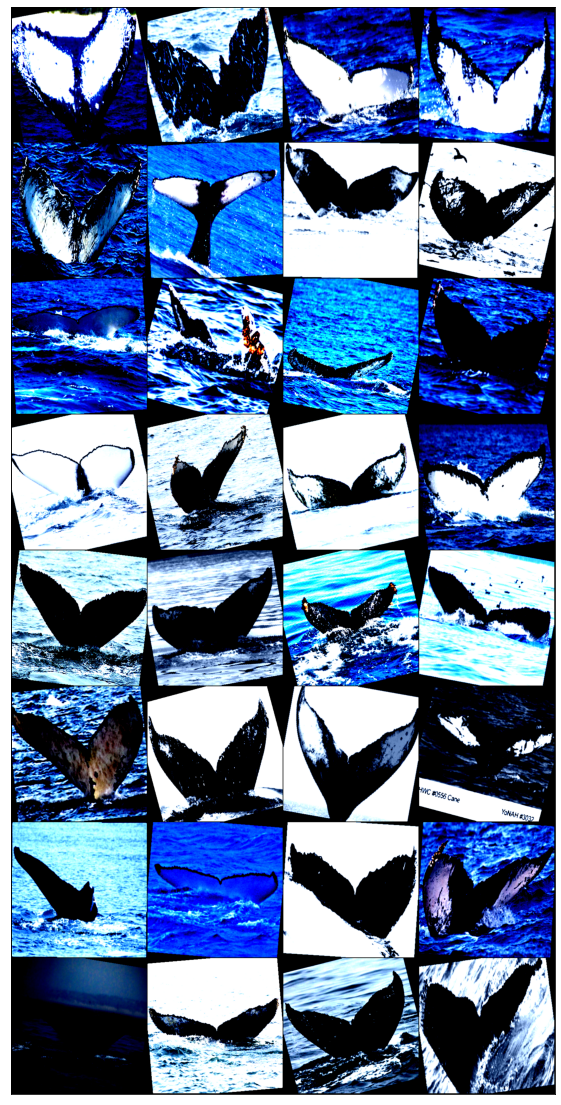

In [14]:
for images, labels in train_loader:
    
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

# Get a Pretrained Model and Frozen Most Layers

import torchvision.models as models
model = models.resnet34(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(p=0.5), 
                         nn.Linear(num_ftrs, 5004))

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay= 1e-6)

In [16]:
model = torch.load("../input/humpbackwhaleresnet34/HumpbackWhale-resnet34.h5")

In [17]:
model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 20 
for epoch in range(num_epochs):

    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0

    for images, labels in tqdm(pretrain_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Train_Acc: %.2f]" \
              %(epoch+1, num_epochs, train_losses[-1], train_accuracy))  

model = torch.load("../input/humpackwhalemodel/HumpbackWhale6.h5")

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

In [19]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 5
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))
    

100%|██████████| 99/99 [01:26<00:00,  1.14it/s]


[Epoch: 1 / 5], [Trian loss: 0.001066], [Val loss: 0.000739], [Train_Acc: 55.84], [Val_Acc: 66.91]


100%|██████████| 99/99 [01:13<00:00,  1.34it/s]


[Epoch: 2 / 5], [Trian loss: 0.000981], [Val loss: 0.000701], [Train_Acc: 56.71], [Val_Acc: 67.17]


100%|██████████| 99/99 [01:14<00:00,  1.33it/s]


[Epoch: 3 / 5], [Trian loss: 0.000935], [Val loss: 0.000681], [Train_Acc: 57.26], [Val_Acc: 67.29]


100%|██████████| 99/99 [01:13<00:00,  1.34it/s]


[Epoch: 4 / 5], [Trian loss: 0.000902], [Val loss: 0.000664], [Train_Acc: 57.70], [Val_Acc: 67.48]


100%|██████████| 99/99 [01:13<00:00,  1.34it/s]

[Epoch: 5 / 5], [Trian loss: 0.000874], [Val loss: 0.000655], [Train_Acc: 58.02], [Val_Acc: 67.61]


In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

In [21]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))
    

100%|██████████| 99/99 [01:15<00:00,  1.31it/s]


[Epoch: 1 / 10], [Trian loss: 0.000854], [Val loss: 0.000642], [Train_Acc: 58.29], [Val_Acc: 67.71]


100%|██████████| 99/99 [01:13<00:00,  1.35it/s]


[Epoch: 2 / 10], [Trian loss: 0.000842], [Val loss: 0.000642], [Train_Acc: 58.42], [Val_Acc: 67.77]


100%|██████████| 99/99 [01:15<00:00,  1.32it/s]


[Epoch: 3 / 10], [Trian loss: 0.000832], [Val loss: 0.000629], [Train_Acc: 58.52], [Val_Acc: 67.90]


100%|██████████| 99/99 [01:13<00:00,  1.34it/s]


[Epoch: 4 / 10], [Trian loss: 0.000823], [Val loss: 0.000631], [Train_Acc: 58.65], [Val_Acc: 67.93]


100%|██████████| 99/99 [01:13<00:00,  1.34it/s]


[Epoch: 5 / 10], [Trian loss: 0.000814], [Val loss: 0.000623], [Train_Acc: 58.76], [Val_Acc: 67.96]


100%|██████████| 99/99 [01:16<00:00,  1.30it/s]


[Epoch: 6 / 10], [Trian loss: 0.000806], [Val loss: 0.000625], [Train_Acc: 58.75], [Val_Acc: 68.06]


100%|██████████| 99/99 [01:14<00:00,  1.33it/s]


[Epoch: 7 / 10], [Trian loss: 0.000799], [Val loss: 0.000616], [Train_Acc: 58.93], [Val_Acc: 68.15]


100%|██████████| 99/99 [01:15<00:00,  1.32it/s]


[Epoch: 8 / 10], [Trian loss: 0.000792], [Val loss: 0.000614], [Train_Acc: 59.05], [Val_Acc: 68.28]


100%|██████████| 99/99 [01:14<00:00,  1.34it/s]


[Epoch: 9 / 10], [Trian loss: 0.000785], [Val loss: 0.000606], [Train_Acc: 59.07], [Val_Acc: 68.25]


100%|██████████| 99/99 [01:13<00:00,  1.34it/s]

[Epoch: 10 / 10], [Trian loss: 0.000778], [Val loss: 0.000600], [Train_Acc: 59.15], [Val_Acc: 68.15]


optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)

In [22]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs.data,1)
        _, int_label = torch.max(labels.data,1)
        train_num_correct += (preds == int_label).sum().item()
        train_num_predictions += labels.size(0)
            
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs.data,1)
            _, int_label = torch.max(labels.data,1)
            val_num_correct += (preds == int_label).sum().item()
            val_num_predictions += labels.size(0)
        
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))
    

100%|██████████| 99/99 [01:14<00:00,  1.33it/s]


[Epoch: 1 / 2], [Trian loss: 0.000772], [Val loss: 0.000600], [Train_Acc: 59.18], [Val_Acc: 68.22]


100%|██████████| 99/99 [01:16<00:00,  1.30it/s]

[Epoch: 2 / 2], [Trian loss: 0.000766], [Val loss: 0.000602], [Train_Acc: 59.28], [Val_Acc: 68.28]


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Save the Model

In [23]:
torch.save(train_loader, 'train_loader.pt')
torch.save(val_loader, 'val_loader.pt')
torch.save(model, "HumpbackWhale-resnet34.h5")

# Testing and Find the Best Threshold

In [ ]:
new_whale_df = df[df["Id"] == "new_whale"]
_, val_new_whale = train_test_split(new_whale_df, test_size=0.1245)
val.shape,val_new_whale.shape

In [ ]:
val = pd.concat((val_new_whale, val), axis = 0)

In [ ]:
model.eval()
pred = None
for i in range(val.shape[0]):
    with torch.no_grad():
        image_name = val["Image"].iloc[i]
        image = Image.open(os.path.join(file_dir,image_name))
        image = image.resize((384,384))
        image = image.convert("RGB")
        image = val_data.transform(image)
        image = image.to(device)
        if pred is None:
            pred = model(image.unsqueeze(0)).cpu().detach().numpy()
        else:
            pred = np.concatenate((pred, model(image.unsqueeze(0)).cpu().detach().numpy()),axis = 0)
pred = np.concatenate((np.zeros((pred.shape[0],1)), pred),axis = 1)
pred

In [ ]:
label_set = ['new_whale']+list(le.classes_)

In [ ]:
def map5(X, y, label_set):
    score = 0
    for i in range(X.shape[0]):
        pred = X[i].argsort()[-5:][::-1]
        for j in range(pred.shape[0]):
            if label_set[pred[j]] == y[i]:
                score += (5 - j)/5
                break
                
    return float(score/X.shape[0])

In [ ]:
best_th = 0
best_score = 0
y = np.array(val["Id"])
for th in np.arange(-1, 1, 0.05):
    pred[:,0] = th
    score = map5(pred, y, label_set)
    if score > best_score:
        best_score = score
        best_th = th
    print("Threshold = {:.3f}, MAP5 = {:.3f}".format(th,score))

In [ ]:
print("Best Threshold = {:.3f}, Best MAP5 = {:.3f}".format(best_th,best_score))

In [ ]:
file_dir  = "../input/humpback-whale-identification/test"
sample = pd.read_csv("../input/humpback-whale-identification/sample_submission.csv")
sample.head()

In [ ]:
model.eval()
pred = None
for i in range(sample.shape[0]):
    with torch.no_grad():
        file_name = sample["Image"][i] 
        image = Image.open(os.path.join(file_dir,file_name))
        image = image.resize((384,384))
        image = image.convert("RGB")
        image = val_data.transform(image)
        image = image.to(device)
        if pred is None:
            pred = model(image.unsqueeze(0)).cpu().detach().numpy()
        else:
            pred = np.concatenate((pred, model(image.unsqueeze(0)).cpu().detach().numpy()),axis = 0)
pred = np.concatenate((np.zeros((pred.shape[0],1)), pred),axis = 1)
pred

In [ ]:
pred[:,0] = best_th

In [ ]:
result = {}
for i in range(pred.shape[0]):
    file_name = sample["Image"][i]
    result[file_name] = ""
    top5 = pred[i].argsort()[-5:][::-1]
    for j in range(top5.shape[0]):
        if result[file_name] != "":
            result[file_name] += " "
            result[file_name] += label_set[top5[j]]
        else:
            result[file_name] += label_set[top5[j]]

In [ ]:
submission = pd.DataFrame(result.items(), columns = ["Image", "Id"])
submission.head()

In [ ]:
submission.to_csv("submission.csv", index = False)